In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import warnings

import numpy as np
import pandas as pd
import torch
from explainer import *
from recbole.data.dataset import SequentialDataset
from recbole.data.interaction import Interaction
from recbole.quick_start.quick_start import load_data_and_model, run_recbole

warnings.filterwarnings("ignore")

In [3]:
(
    config_1,
    model_1,
    dataset_1,
    train_data_1,
    valid_data_1,
    test_data_1,
) = load_data_and_model("saved/GRU4Rec-Mar-20-2023_14-29-56.pth")

27 Mar 09:57    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = /home/ashrimal2/anaconda3/lib/python3.9/site-packages/recbole/config/../dataset_example/ml-100k
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 300
train_batch_size = 2048
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'LS': 'valid_and_test'}, 'order': 'TO', 'mode': 'full', 'group_by': 'user'}
repeatable = True
metrics = ['Recall', 'MRR', 'NDCG', 'Hit', 'Precision']
topk = [10]
valid_metric = MRR@10
valid_metric_bigger = True
eval_batch_size = 

In [4]:
def convert_to_dataframe(dataset: SequentialDataset) -> pd.DataFrame:
    # Get the number of instances in the dataset
    n = len(dataset)

    # Loop through the dataset and extract interactions as dictionaries
    dicts = [dataset[i].interaction for i in range(n)]

    # Convert the list of dictionaries to a Pandas DataFrame
    df = pd.DataFrame(dicts)

    # Convert tensors to numpy arrays
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x.numpy())

    return df

In [5]:
train_df = convert_to_dataframe(train_data_1.dataset)

In [6]:
test_df = convert_to_dataframe(test_data_1.dataset)

In [7]:
# Select sequences to explain
positive_sequence_id = np.random.choice(test_df.user_id.unique())
pos_x_pd = test_df[test_df["user_id"] == positive_sequence_id]

In [8]:
pos_x_pd

,user_id,item_id,rating,timestamp,item_length,item_id_list,rating_list,timestamp_list
864,143,5,0.5,0.897047,50,"[215, 737, 951, 262, 269, 140, 116, 961, 1410,...","[0.75, 0.0, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, ...","[0.89700586, 0.89700586, 0.89700586, 0.8970058..."


In [9]:
input_interaction = pd_to_interaction(pos_x_pd, config_1)

In [10]:
input_interaction

{'user_id': tensor([[143]], device='cuda:0'),
 'item_id': tensor([5], device='cuda:0'),
 'item_length': tensor([50], device='cuda:0'),
 'item_id_list': tensor([[ 215,  737,  951,  262,  269,  140,  116,  961, 1410,  642, 1549,  252,
           653, 1561,  840,  421, 1230,  891,   99,  185,  882,  555, 1001,  852,
           270,  610,  631,   96,  361,  145, 1262,  816,  275, 1117, 1445,  667,
           931,  336,  512,  701,  326,  290,   73, 1167,  131,  398, 1275,  960,
          1403,  861]], device='cuda:0')}

In [11]:
model_1.predict(input_interaction)

tensor([7.2366], device='cuda:0', grad_fn=<SumBackward1>)

In [12]:
def most_popular_item():
    popular_item = train_df["item_id"].value_counts().idxmax()
    return popular_item

In [13]:
def random_item():
    unique_items = train_df["item_id"].unique()
    random_item = random.choice(unique_items)
    return random_item

In [14]:
explainer = SeqExplainer(model_1)
shap_values = explainer.explain(
    input_interaction, replacement_func=random_item, num_samples=100
)

In [15]:
shap_values

array([-0.68037271, -0.11585951, -1.12826777,  0.68360949,  0.29217529,
       -0.27345276,  0.92179775, -1.69804811, -1.17586613, -0.12898445,
        1.20713425, -0.11136484, -1.49181318, -0.06245184, -0.79625082,
       -0.93729877,  1.77597952, -0.07284927,  1.18794155,  0.14886904,
        0.41848755, -0.20160627,  0.21271801, -0.62880707,  0.38818932,
       -0.10217047, -0.22945213, -1.08207369, -0.63306713, -0.91110563,
       -0.59237194, -1.01236916,  0.29286623, -0.88370991,  0.01791668,
       -0.50292206, -1.09311962, -0.06077671,  0.54199076, -0.03592396,
       -1.1173296 , -0.96749687,  0.14804173, -0.93260431, -0.8372879 ,
       -0.62054348, -0.56258011,  0.61767721,  1.02293682,  5.25321198])

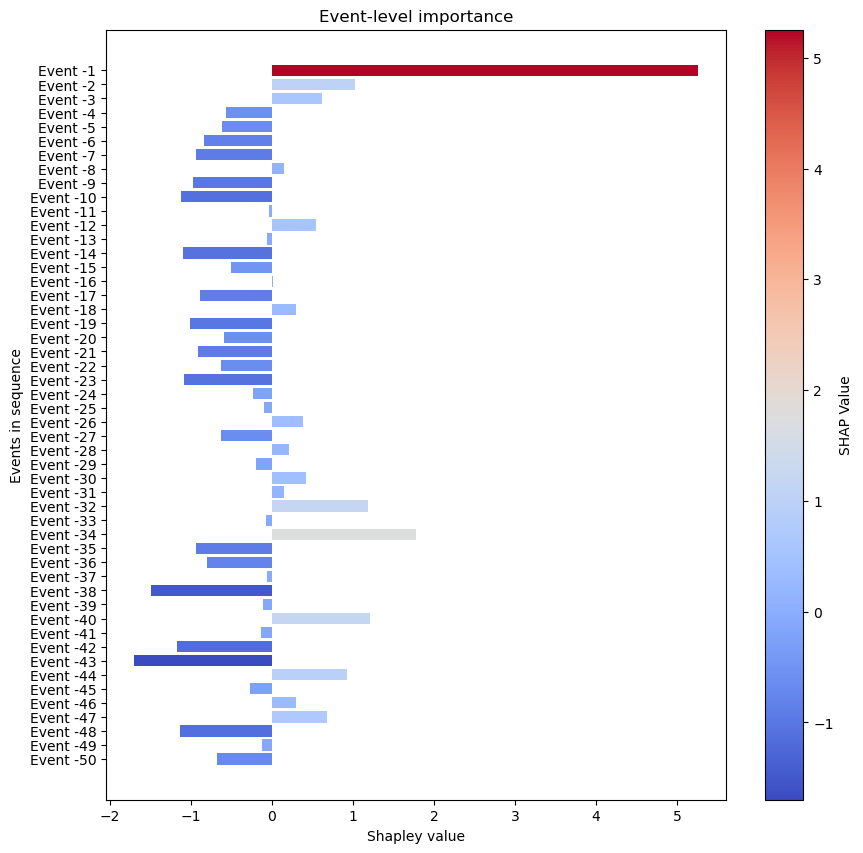

In [16]:
sequence = input_interaction["item_id_list"][0].tolist()
plot_shap_values(shap_values, sequence)

In [17]:
movies = pd.read_csv(
    "~/anaconda3/lib/python3.9/site-packages/recbole/dataset_example/ml-100k/ml-100k.item",
    sep="\t",
)

In [18]:
movies

,item_id:token,movie_title:token_seq,release_year:token,class:token_seq
0,1,Toy Story,1995,Animation Children's Comedy
1,2,GoldenEye,1995,Action Adventure Thriller
2,3,Four Rooms,1995,Thriller
3,4,Get Shorty,1995,Action Comedy Drama
4,5,Copycat,1995,Crime Drama Thriller
...,...,...,...,...
1677,1678,Mat' i syn,1997,Drama
1678,1679,B. Monkey,1998,Romance Thriller
1679,1680,Sliding Doors,1998,Drama Romance
1680,1681,You So Crazy,1994,Comedy


In [19]:
print_topk_movies(shap_values, sequence, dataset_1, input_interaction, movies, 10)

Query movie info:
Movie Title: Copycat
Release Year: 1995
Class: Crime Drama Thriller

Top-k movies:
Movie Title: Nosferatu a Venezia
Release Year: 1986
Class: Horror
SHAP: 5.253211975097656

Movie Title: Ready to Wear (Pret-A-Porter)
Release Year: 1994
Class: Comedy
SHAP: 1.7759795188903809

Movie Title: Orlando
Release Year: 1993
Class: Drama
SHAP: -1.6980481147766113

Movie Title: Touch of Evil
Release Year: 1958
Class: Crime Film-Noir Thriller
SHAP: -1.4918131828308105

Movie Title: Dream Man
Release Year: 1995
Class: Thriller
SHAP: 1.2071342468261719

Movie Title: Snow White and the Seven Dwarfs
Release Year: 1937
Class: Animation Children's Musical
SHAP: 1.187941551208496

Movie Title: Harlem
Release Year: 1993
Class: Drama
SHAP: -1.1758661270141602

Movie Title: Indian in the Cupboard, The
Release Year: 1995
Class: Adventure Children's Fantasy
SHAP: -1.128267765045166

Movie Title: G.I. Jane
Release Year: 1997
Class: Action Drama War
SHAP: -1.1173295974731445

Movie Title: Islan